## **Analyse Dataset Varience**

To effectively utilise Gaussian processes, we must address its limitation in modelling high-dimensional datasets. We advise keeping the dimensionality to around 20 for optimal performance. Additionally, training on lower-dimensional data allows you to save time and computational resources.

Twinlab employs dimensionality reduction techniques and provides users with the option to specify the number of dimensions or the amount they wish to train on. These methods streamline the data, making it feasible to apply GPs on datasets with higher dimensions.

This notebook will explain how to utilise the analyse_input_variance and analyse_output_variance methods on your dataset to make informed decisions about the dataset you wish to train.

In [99]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import sin

# twinLab import
import twinlab as tl

In [100]:
tl.versions()

{'cloud': '2.0.0',
 'modal': '0.2.0',
 'library': '1.4.0',
 'image': 'twinlab-micol'}

Dimensionality reduction works by using statistical techniques to find correlations between dimensions. It relies on the principle that highly correlated variables contribute minimal aditional information and so captures the essential structure in fewer dimensions. The variance retained per dimension directly indicates how much of the dataset's original variability is preserved, offering insight into the amount of information that can be sumarised in each variable.

We will begin by showing how this is works on a dataframe where the variables that are very correlated

In [101]:
# Define the df you want to use
list1 = list(range(100))

example_df = pd.DataFrame({"A":list1, "B": [i**2 for i in list1],"C":[i**3-sin(i) for i in list1]})
example_df

,A,B,C
0,0,0,0.000000
1,1,1,0.158529
2,2,4,7.090703
3,3,9,26.858880
4,4,16,64.756802
...,...,...,...
95,95,9025,857374.316738
96,96,9216,884735.016412
97,97,9409,912672.620392
98,98,9604,941192.573382


In [102]:
# define a dataset
example_dataset = tl.Dataset("example")

# Upload Your dataset
example_dataset.upload(df=example_df)

# Printing dataset to understand it better adn making sure it is uploaded
print(example_dataset.view())
print(example_dataset.summarise())

     A     B              C
0    0     0       0.000000
1    1     1       0.158529
2    2     4       7.090703
3    3     9      26.858880
4    4    16      64.756802
..  ..   ...            ...
95  95  9025  857374.316738
96  96  9216  884735.016412
97  97  9409  912672.620392
98  98  9604  941192.573382
99  99  9801  970299.999207

[100 rows x 3 columns]
                A            B              C
count  100.000000   100.000000     100.000000
mean    49.500000  3283.500000  245024.996208
std     29.011492  2968.174804  280457.604901
min      0.000000     0.000000       0.000000
25%     24.750000   612.750000   15175.075658
50%     49.500000  2450.500000  121325.108064
75%     74.250000  5513.250000  409387.585805
max     99.000000  9801.000000  970299.999207


In the dataframe above, columns B and C are functions of column A. Therefore, training a model on just A or with all of the columns would not add additional information. 

By analysing this dataframe with the analyse_input_variance function, we will be able to see that the dataset's information can be mostly captured by column A. 

In [92]:
example_dataset.analyse_input_variance(columns=["A","B","C"])

,Number of Dimensions,Cumulative Variance
0,0,0.000000
1,1,0.999995
2,2,1.000000
3,3,1.000000


As you can see almost all of the information can be summarized with just one input.

In [93]:
# deleting the dataset
example_dataset.delete()

## Real dataset example

Below, we demonstrate how to utilise the same technique on a real dataset we want to train on. This dataset is one of the example datasets available in Twinlab, Which can easily be loaded as shown. 

In [ ]:
tl.list_example_datasets()

In [94]:
df_train = tl.load_example_dataset("fusion")

# Instanciating and uploading dataset
training_dataset = tl.Dataset("fusion_dataset")
training_dataset.upload(df_train)

# defining the inputs and outputs
input_columns = ["E1", "E2", "E3", "n1", "n2"]
output_columns = [f"y{i}" for i in range(0, df_train.shape[1]-len(input_columns))]

In [95]:
training_dataset.summarise()

,E1,E2,E3,n1,n2,y0,y1,y2,y3,y4,...,y614,y615,y616,y617,y618,y619,y620,y621,y622,y623
count,400.000000,400.000000,400.000000,400.000000,400.000000,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,...,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02
mean,0.847811,1.096564,1.439218,0.002780,0.000550,6.361675e+16,6.873802e+16,7.426884e+16,8.022546e+16,8.661425e+16,...,1.576280e+17,1.556983e+17,1.537915e+17,1.519250e+17,1.501097e+17,1.483684e+17,1.466999e+17,1.450814e+17,1.435212e+17,1.420506e+17
std,0.086283,0.113226,0.183739,0.001264,0.000254,6.795742e+16,7.317686e+16,7.878150e+16,8.479061e+16,9.120958e+16,...,1.292721e+17,1.276754e+17,1.260886e+17,1.245359e+17,1.230176e+17,1.216074e+17,1.202565e+17,1.189713e+17,1.177443e+17,1.165804e+17
min,0.700338,0.902457,1.103538,0.000522,0.000100,1.963621e+14,2.115386e+14,2.298551e+14,2.515298e+14,2.763921e+14,...,1.460660e+16,1.447977e+16,1.435294e+16,1.422611e+16,1.409927e+16,1.397244e+16,1.385901e+16,1.379510e+16,1.373119e+16,1.366728e+16
25%,0.776996,1.004006,1.280775,0.001742,0.000322,3.537697e+15,3.885903e+15,4.276821e+15,4.708195e+15,5.180239e+15,...,5.655948e+16,5.534897e+16,5.479281e+16,5.426104e+16,5.364998e+16,5.317452e+16,5.268290e+16,5.221749e+16,5.175208e+16,5.128668e+16
50%,0.846752,1.089826,1.435188,0.002727,0.000586,3.677477e+16,3.990621e+16,4.332506e+16,4.702728e+16,5.106477e+16,...,1.074164e+17,1.056007e+17,1.036920e+17,1.023300e+17,1.009598e+17,9.926862e+16,9.720451e+16,9.593318e+16,9.500944e+16,9.441496e+16
75%,0.923479,1.195031,1.588289,0.003888,0.000756,1.154598e+17,1.245779e+17,1.343340e+17,1.446751e+17,1.557012e+17,...,2.294064e+17,2.254695e+17,2.217749e+17,2.188035e+17,2.164698e+17,2.153460e+17,2.142763e+17,2.121939e+17,2.109158e+17,2.095455e+17
max,0.997323,1.299867,1.748338,0.004999,0.000995,2.376907e+17,2.553641e+17,2.743015e+17,2.945655e+17,3.161688e+17,...,5.888639e+17,5.804446e+17,5.720253e+17,5.663434e+17,5.610157e+17,5.556881e+17,5.518733e+17,5.513362e+17,5.507992e+17,5.502622e+17


In [96]:
input_variance_df = training_dataset.analyse_input_variance(columns=input_columns)
output_variance_df = training_dataset.analyse_output_variance(columns=output_columns)

print(input_variance_df)
print(output_variance_df)

   Number of Dimensions  Cumulative Variance
0                     0             0.000000
1                     1             0.406099
2                     2             0.813714
3                     3             0.999969
4                     4             0.999999
5                     5             1.000000
     Number of Dimensions  Cumulative Variance
0                       0             0.000000
1                       1             0.265579
2                       2             0.734992
3                       3             0.895238
4                       4             0.969070
..                    ...                  ...
396                   396             1.000000
397                   397             1.000000
398                   398             1.000000
399                   399             1.000000
400                   400             1.000000

[401 rows x 2 columns]


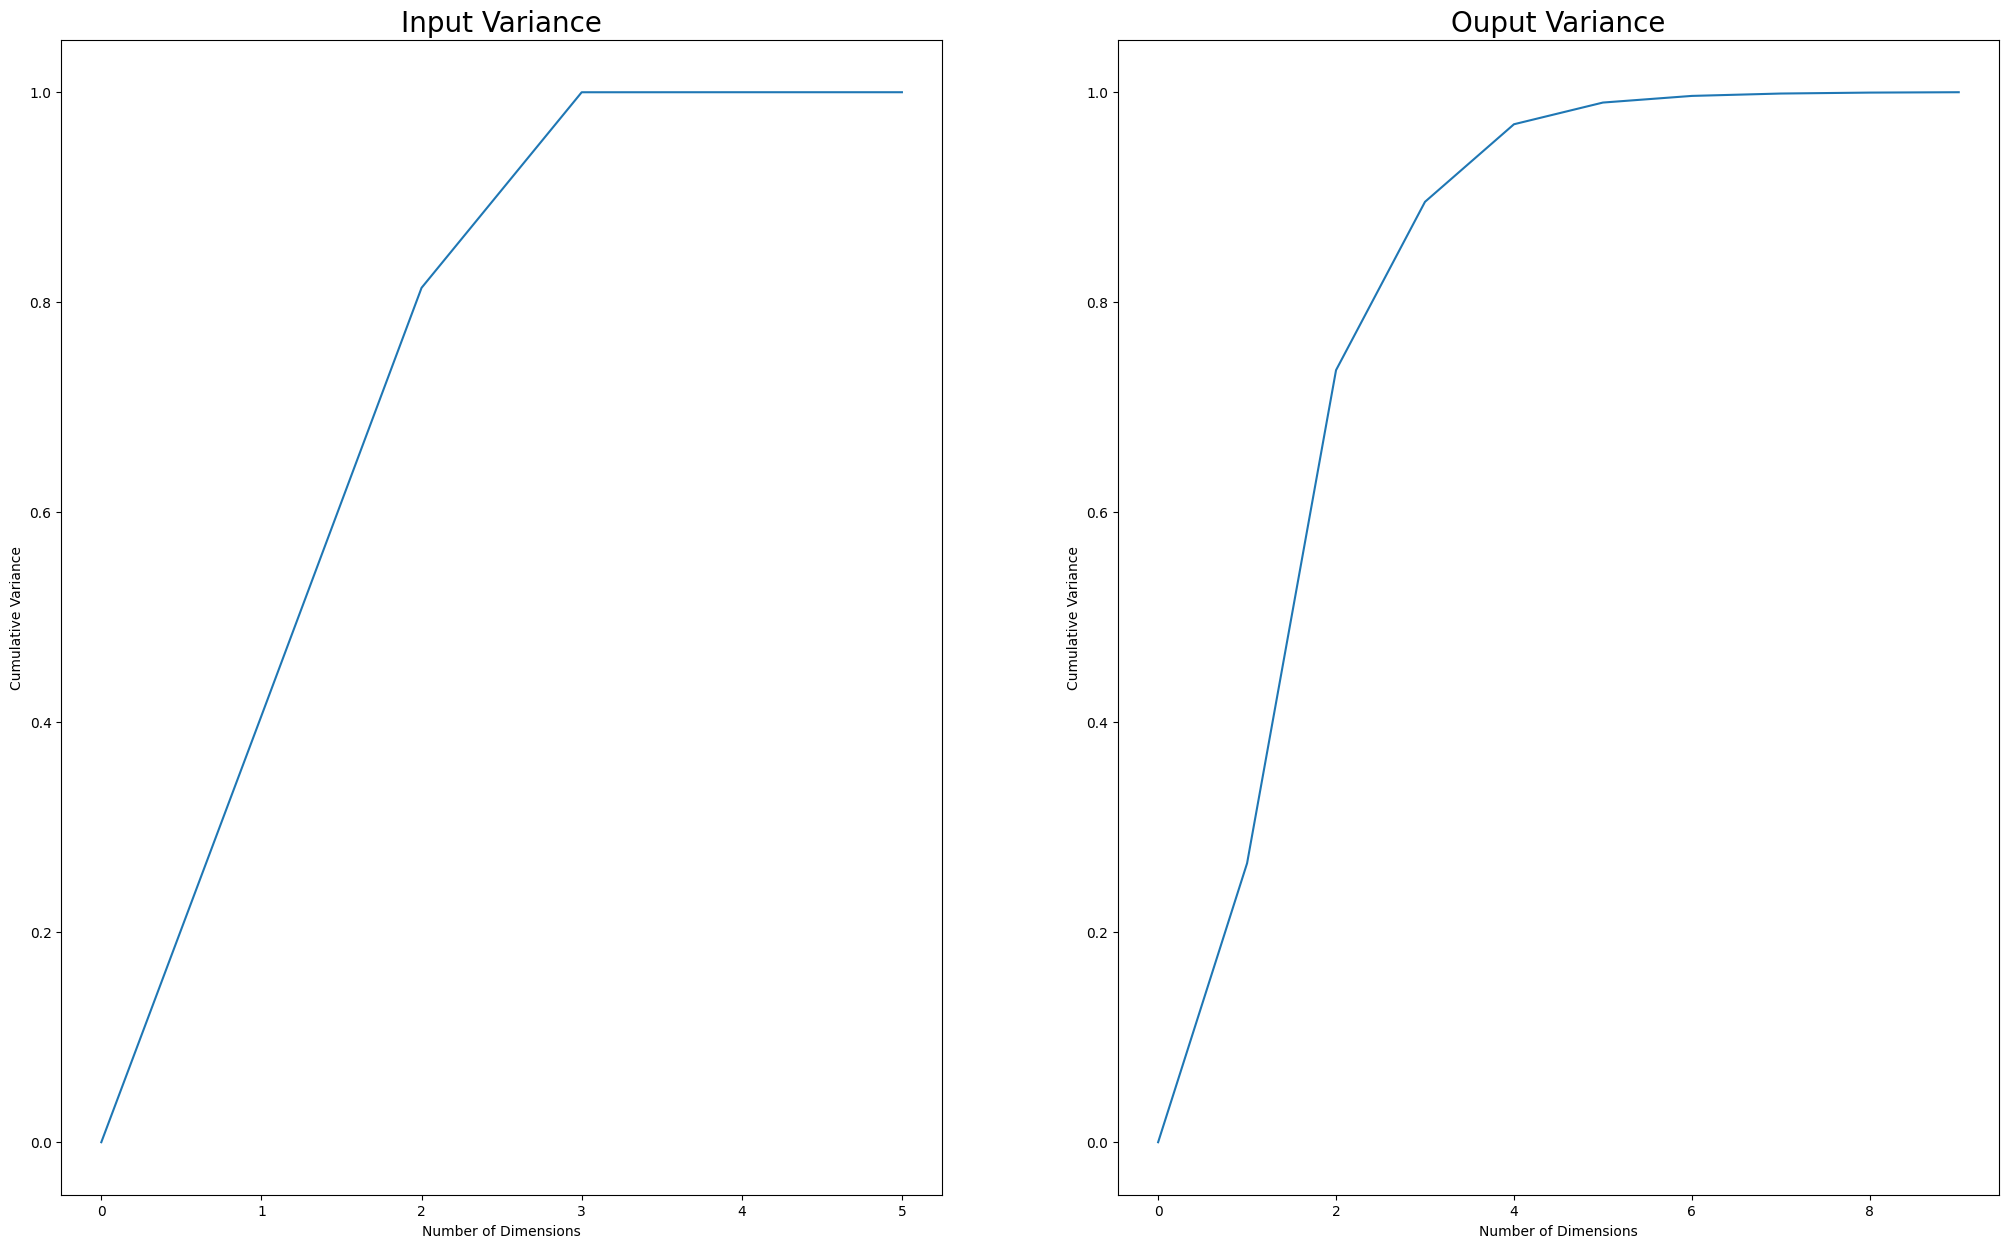

In [116]:

plt.subplots(1, 2, figsize=(25,15))

# Plot the first dataframe on the first subplot
plt.subplot(1, 2, 1)
plt.title("Input Variance", fontsize = 20)
plt.plot(input_variance_df["Number of Dimensions"], input_variance_df["Cumulative Variance"])
plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Variance")

# Plot the second dataframe on the second subplot
plt.subplot(1, 2, 2)
plt.title("Ouput Variance", fontsize = 20)
plt.plot(output_variance_df["Number of Dimensions"][:10], output_variance_df["Cumulative Variance"][:10])
plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Variance")

plt.show()

The plots show how most of the variance can be captured with a much lower dimensional dataset for both the input and the output the next notebook shows how to implement this in training

In [117]:
# Delte dataset
training_dataset.delete()
